<a href="https://colab.research.google.com/github/Jalalbaim/Auto-Encoder/blob/main/Variational_Auto_Encoder_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Variational auto encoder**
BAIM Mohamed Jalal
***


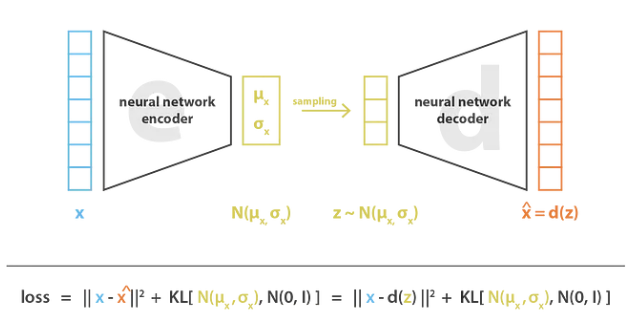

## **Libraries:**
***

In [ ]:
# Libraries

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import nn, optim
from tqdm import tqdm
from collections import defaultdict

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## **Datasets: Fashion Mnist & Mnist**
***

### **Fashion MNIST**


In [ ]:
# Dataset
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [ ]:
# Labels
label_index = training_data.targets[0]
label_name = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
][label_index]

print("Label index:", label_index)
print("Label name:", label_name)

Label index: tensor(9)
Label name: Ankle boot


In [ ]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


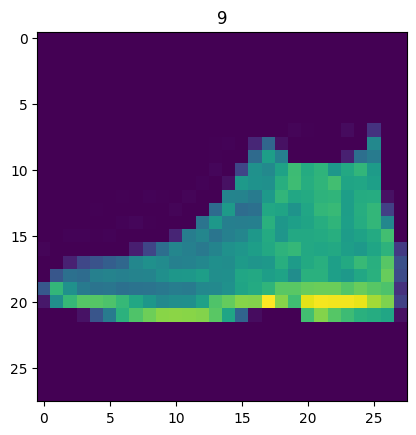

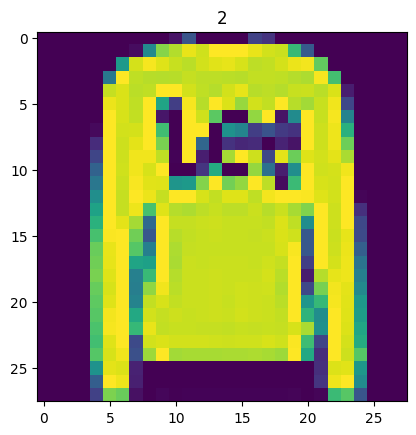

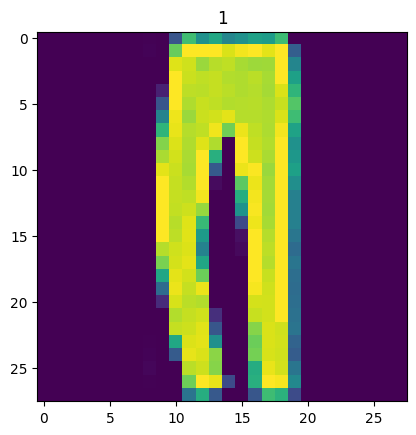

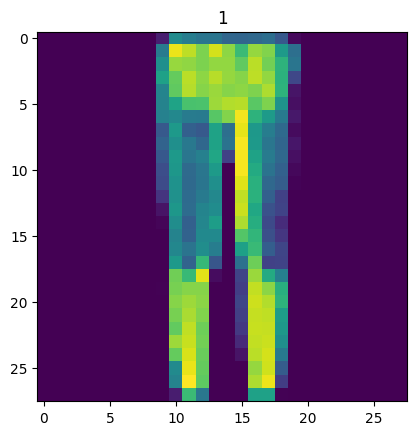

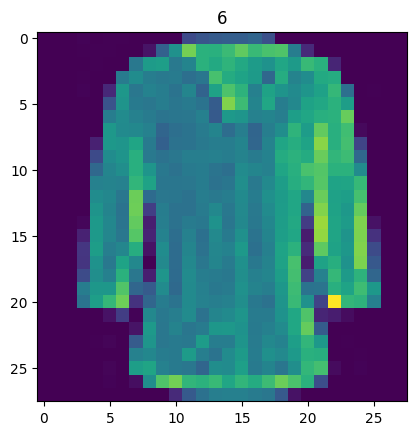

In [ ]:
# visualization de Fashion MNIST
for i in range(5):
  image, label = test_data[i]
  plt.imshow(image.cpu().reshape(28,28))
  plt.title(label)
  plt.axis('on')
  plt.show()

### **MNIST**


In [ ]:
# Dataset
training_data_MNIST = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)
test_data_MNIST = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [ ]:
batch_size = 64

train_dataloader_MNIST = DataLoader(training_data_MNIST, batch_size=batch_size)
test_dataloader_MNIST = DataLoader(test_data_MNIST, batch_size=batch_size)

for X, y in test_dataloader_MNIST:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


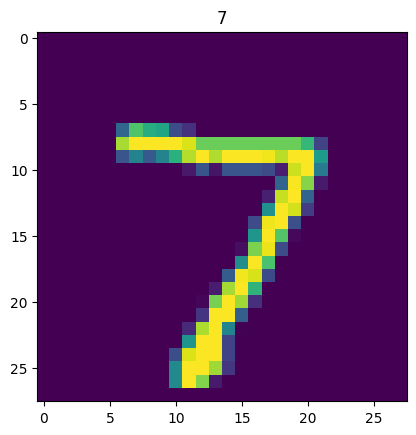

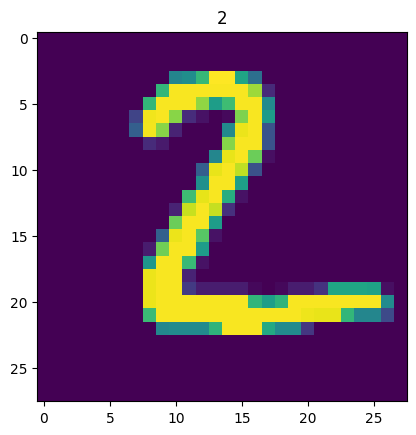

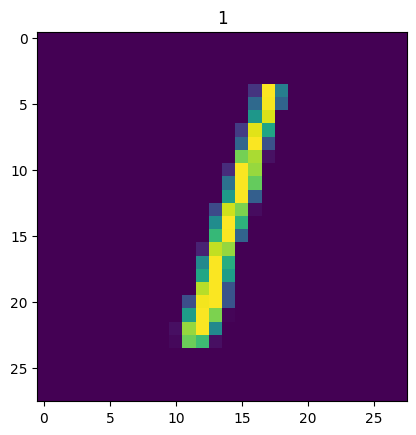

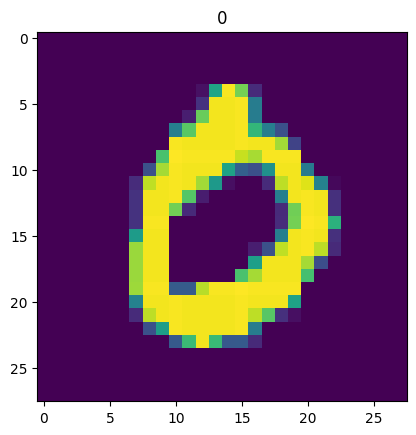

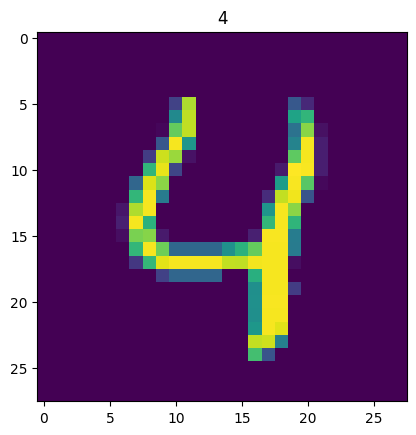

In [ ]:
# Visualisation de quelques images de la base de données
for i in range(5):
  image, label = test_data_MNIST[i]
  plt.imshow(image.cpu().reshape(28,28))
  plt.title(label)
  plt.axis('on')
  plt.show()

## **Variational auto encoder VAE**
***

In [ ]:
class VAE_base(nn.Module):
    def __init__(self, encoder, decoder, latent_dim):
        super(VAE_base, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.latent_dim = latent_dim

    def forward(self, x):
        encoded = self.encoder(x)
        z_mean = encoded[:, :self.latent_dim]
        z_log_var = encoded[:, self.latent_dim:]
        z = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(z)
        return decoded, z_mean, z_log_var, z

    def reparameterize(self, z_mean, z_log_var):
        std =  torch.sqrt(torch.exp(z_log_var))
        eps = torch.randn_like(std)
        return z_mean + eps * std

class VAutoEncoder(VAE_base):
    def __init__(self, input_dim, latent_dim):
        encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 256),
            nn.Tanh(),
            nn.Linear(256, 2 * latent_dim)
        )
        decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )
        super(VAutoEncoder, self).__init__(encoder=encoder, decoder=decoder, latent_dim=latent_dim)


In [ ]:
def loss_fn(decoded, x, z_mean, z_log_var):
    """
    Fonction loss
    """
    batch_size = x.size(0)

    # assurer le log
    decoded = torch.clamp(decoded, 1e-8, 1 - 1e-8)

    # Reconstruction loss: mean square error MSE
    recon_loss = F.mse_loss(decoded, x, reduction='sum') / batch_size

    # KL divergence
    kl_divergence = 0.5 * torch.sum(
        torch.exp(z_log_var) + z_mean**2 - 1. - z_log_var
    ) / batch_size

    # Total loss
    total_loss = recon_loss + kl_divergence

    return total_loss, recon_loss, kl_divergence

In [ ]:
def train_vae(model, dataloader, optimizer, loss_fn, device, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()

        # Forward
        decoded, z_mean, z_log_var, z = model(data)
        decoded_reshaped = decoded.view_as(data)

        # loss
        total_loss, recon_loss, kl_divergence = loss_fn(decoded_reshaped, data, z_mean, z_log_var)

        # Backpropagation
        total_loss.backward()
        optimizer.step()

        train_loss += total_loss.item()

        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(dataloader.dataset)} ({100. * batch_idx / len(dataloader):.0f}%)]\tLoss: {total_loss.item():.6f}')

    average_loss = train_loss / len(dataloader)
    print(f"Average Loss: {average_loss:.4f}")
    return average_loss

In [ ]:
# visualize reconstruction
def visualize_reconstructions(model, dataloader, num_images=5):
    """
    La fonction permet de visualiser la reconstruction des images en entrée
    """
    model.eval()
    figure, axes = plt.subplots(2, num_images, figsize=(10, 4))

    with torch.no_grad():
        for i, (data, _) in enumerate(dataloader):
            if i >= num_images:
                break
            data = data.to(next(model.parameters()).device)
            reconstruction, _, _, _ = model(data.view(data.size(0), -1))

            original = data.view(data.shape[0], 28, 28)
            recon = reconstruction.view(reconstruction.shape[0], 28, 28)

            ax = axes[0, i]
            ax.imshow(original[i].cpu().numpy())
            ax.axis('off')
            ax.set_title('Original')

            ax = axes[1, i]
            ax.imshow(recon[i].cpu().numpy())
            ax.axis('off')
            ax.set_title('Reconstructed')

    plt.show()

In [ ]:
# visualize latent space
def visualize_latent_space(model, dataloader, device):
    """
    Cette fonction permet de visualiser l'espace latent en 2 dimensions
    """
    model.eval()
    model.to(device)
    zs = defaultdict(list)
    COLORS = ['red', 'blue', 'green', 'yellow', 'orange', 'cyan', 'gray', 'black', 'purple', 'pink']

    batch_count = 0
    for data, labels in tqdm(dataloader, desc='Processing'):
        data = data.to(device)
        with torch.no_grad():
            output = model(data)
        z_means = output[1]

        for label, z_mean in zip(labels, z_means):
            zs[label.item()].append(z_mean.detach().cpu())

        batch_count += 1

    zs = {k: torch.stack(v) for k, v in zs.items()}
    zs = dict(sorted(zs.items()))

    plt.figure(figsize=(12, 8))
    for i, (label, z) in enumerate(zs.items()):
        z = z.numpy()
        plt.scatter(z[:, 0], z[:, 1], color=COLORS[i % len(COLORS)], label=f'Label {label}')

    plt.legend()
    plt.title('Latent Space')
    plt.xlabel('dimension 1')
    plt.ylabel('dimension 2')
    plt.show()

In [ ]:
def generate_samples_from_prior(decoder, latent_dim, num_samples, device, n_row = 2, n_col = 5):
    """
    Je génère des échantillons à partir de la distribution a priori en utilisant le décodeur.
    Cette fonction prend en entrée le décodeur, la dimension latente, le nombre d'échantillons à générer.
    """
    z_prior = torch.randn(num_samples, latent_dim).to(device)
    generated_samples = decoder(z_prior)
    samples = generated_samples.cpu().detach().numpy()

    fig, axes = plt.subplots(n_row, n_col, figsize=(n_col * 3, n_row * 3))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(samples[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.suptitle("Generated samples from prior")
    plt.show()


def generate_samples_from_posterior(model, data, device, n_row=2, n_col=5):
    """
    Je génère des échantillons à partir de la distribution a posteriori qui est
    la distribution des variables latentes conditionnée par les données observées.
    Cette fonction prend en entrée le modèle VAE et les données d'entrée.

    Output:  échantillons générés qui ne correspondent pas directement aux
    entrées originales mais sont des nouvelles instances générées basées sur
    une distribution apprise.
    """
    model.eval()
    with torch.no_grad():
        data = data.to(device)
        data = data.view(data.size(0), -1)
        _, z_mean, z_log_var, _ = model(data)
        z = model.reparameterize(z_mean, z_log_var)
        reconstructed_data = model.decoder(z)

    samples = reconstructed_data.cpu().numpy()

    fig, axes = plt.subplots(n_row, n_col, figsize=(n_col * 3, n_row * 3))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(samples[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.suptitle("Generated samples from posterior")
    plt.show()


## **Application du VAE sur Fashion MNIST**
***

In [ ]:
vae_FMNIST = VAutoEncoder(28*28, 2).to(device)
dataloader = train_dataloader
optimizer = optim.Adam(vae_FMNIST.parameters(), lr=1e-3)

"""
loss_fn = nn.BCELoss(reduction = 'sum')
"""
epochs = 10

for epoch in range(epochs):
  print("--------------------------")
  print(f"Epoch {epoch}")
  train_vae(vae_FMNIST, dataloader, optimizer, loss_fn, device ,epoch)


--------------------------
Epoch 0
Epoch: 0 [0/60000 (0%)]	Loss: 137.642090
Epoch: 0 [6400/60000 (11%)]	Loss: 36.501015
Epoch: 0 [12800/60000 (21%)]	Loss: 35.448322
Epoch: 0 [19200/60000 (32%)]	Loss: 31.829454
Epoch: 0 [25600/60000 (43%)]	Loss: 34.767666
Epoch: 0 [32000/60000 (53%)]	Loss: 34.258686
Epoch: 0 [38400/60000 (64%)]	Loss: 29.947399
Epoch: 0 [44800/60000 (75%)]	Loss: 30.342794
Epoch: 0 [51200/60000 (85%)]	Loss: 32.039509
Epoch: 0 [57600/60000 (96%)]	Loss: 29.963095
Average Loss: 36.1559
--------------------------
Epoch 1
Epoch: 1 [0/60000 (0%)]	Loss: 31.703629
Epoch: 1 [6400/60000 (11%)]	Loss: 30.139286
Epoch: 1 [12800/60000 (21%)]	Loss: 30.785913
Epoch: 1 [19200/60000 (32%)]	Loss: 29.981531
Epoch: 1 [25600/60000 (43%)]	Loss: 32.696465
Epoch: 1 [32000/60000 (53%)]	Loss: 33.498734
Epoch: 1 [38400/60000 (64%)]	Loss: 28.550484
Epoch: 1 [44800/60000 (75%)]	Loss: 29.136396
Epoch: 1 [51200/60000 (85%)]	Loss: 31.195309
Epoch: 1 [57600/60000 (96%)]	Loss: 29.001358
Average Loss: 31.50

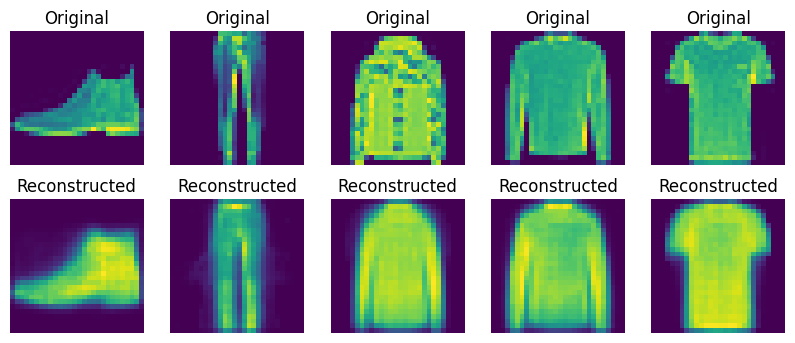

In [ ]:
# visualisation sur Fashion MNIST
visualize_reconstructions(vae_FMNIST, test_dataloader)

Processing: 100%|██████████| 157/157 [00:03<00:00, 42.27it/s]


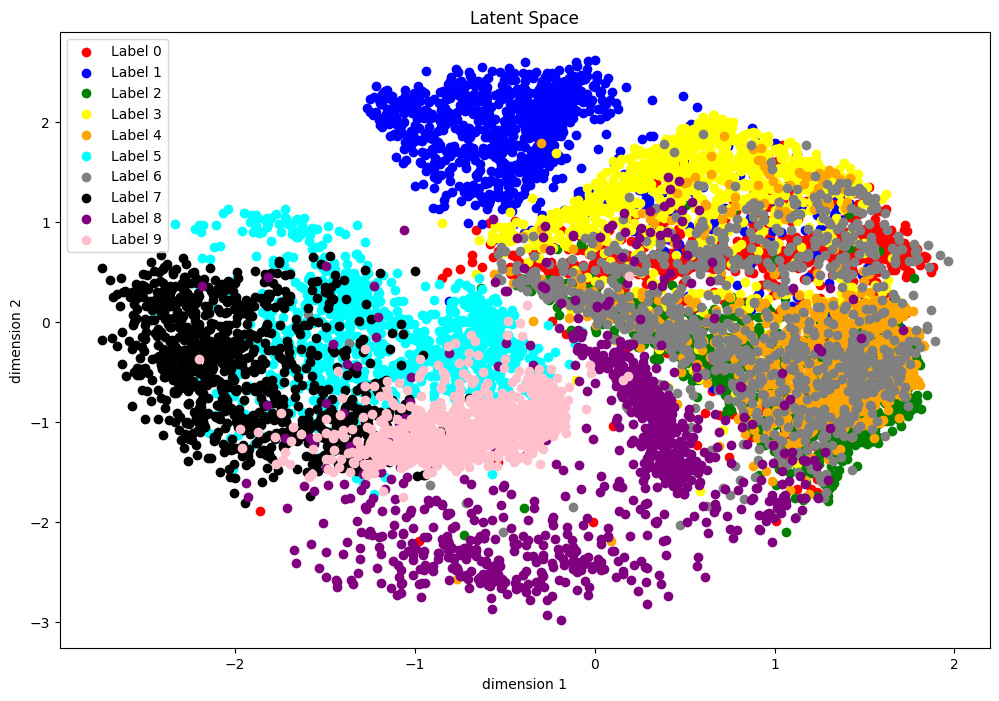

In [ ]:
visualize_latent_space(vae_FMNIST, test_dataloader, device)

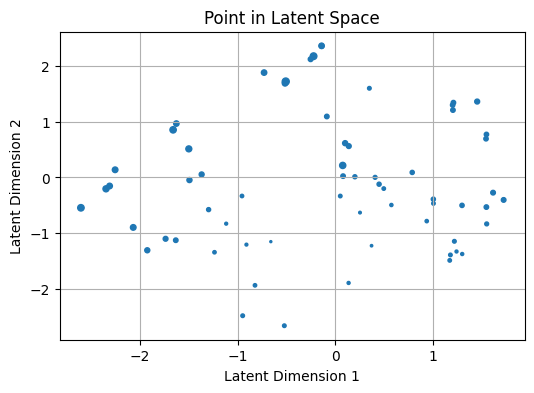

In [ ]:
vae_FMNIST.eval()

data, _ = next(iter(test_dataloader))
data = data.to(device)

with torch.no_grad():
    _, z_mean, z_log_var, _ = vae_FMNIST(data)

    z_var = torch.exp(z_log_var)

    # Calculate point sizes (proportional to the variance)
    point_sizes = z_var.cpu().numpy() * 1000  # Adjust scaling factor to taste

    # Ensure point_sizes is scalar or matches the number of points
    #point_sizes = np.maximum(point_sizes,)  # Ensure minimal visible size

    # Plot the first two dimensions of z_mean in the latent space
    plt.figure(figsize=(6, 4))
    plt.scatter(z_mean.cpu().numpy()[:, 0], z_mean.cpu().numpy()[:, 1], s=point_sizes[:,0])
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Point in Latent Space')
    plt.grid(True)
    plt.show()

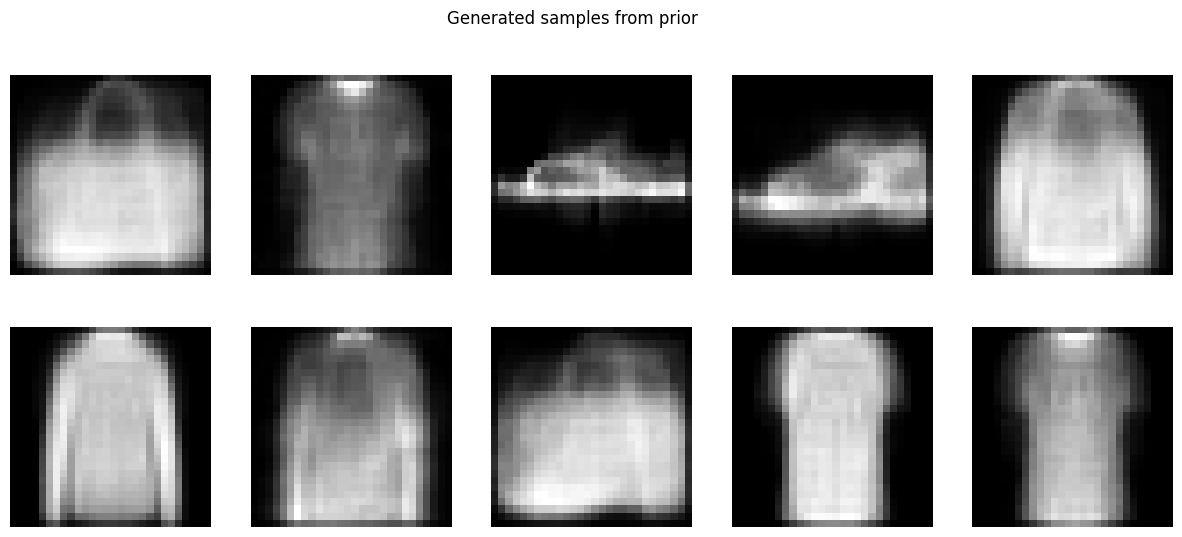

In [ ]:
generate_samples_from_prior(vae_FMNIST.decoder, 2,10, "cuda", 2,5)

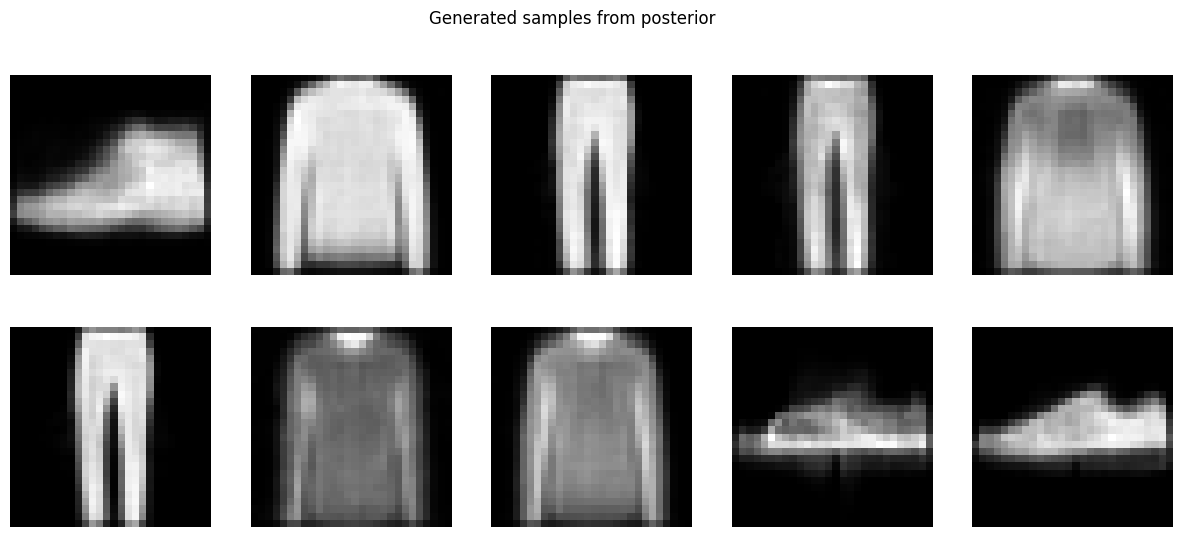

In [ ]:

num_samples = 10
data = next(iter(test_dataloader))[0][:num_samples]
device = 'cuda' if torch.cuda.is_available() else 'cpu'

generate_samples_from_posterior(vae_FMNIST, data, device, 2, 5)

## **Application du VAE sur MNIST**
***

In [ ]:
vae_MNIST = VAutoEncoder(28*28, 2).to(device)
dataloader = train_dataloader_MNIST
optimizer = optim.Adam(vae_MNIST.parameters(), lr=1e-3)

epochs = 10

for epoch in range(epochs):
  print("--------------------------")
  print(f"Epoch {epoch}")
  train_vae(vae_MNIST, dataloader, optimizer, loss_fn, device ,epoch)

--------------------------
Epoch 0
Epoch: 0 [0/60000 (0%)]	Loss: 187.009201
Epoch: 0 [6400/60000 (11%)]	Loss: 52.959064
Epoch: 0 [12800/60000 (21%)]	Loss: 45.802410
Epoch: 0 [19200/60000 (32%)]	Loss: 51.790218
Epoch: 0 [25600/60000 (43%)]	Loss: 46.114136
Epoch: 0 [32000/60000 (53%)]	Loss: 45.705273
Epoch: 0 [38400/60000 (64%)]	Loss: 41.549927
Epoch: 0 [44800/60000 (75%)]	Loss: 43.659859
Epoch: 0 [51200/60000 (85%)]	Loss: 48.958858
Epoch: 0 [57600/60000 (96%)]	Loss: 42.341240
Average Loss: 47.9497
--------------------------
Epoch 1
Epoch: 1 [0/60000 (0%)]	Loss: 41.542786
Epoch: 1 [6400/60000 (11%)]	Loss: 42.888306
Epoch: 1 [12800/60000 (21%)]	Loss: 40.976120
Epoch: 1 [19200/60000 (32%)]	Loss: 47.141933
Epoch: 1 [25600/60000 (43%)]	Loss: 42.152760
Epoch: 1 [32000/60000 (53%)]	Loss: 42.565830
Epoch: 1 [38400/60000 (64%)]	Loss: 39.645977
Epoch: 1 [44800/60000 (75%)]	Loss: 41.667900
Epoch: 1 [51200/60000 (85%)]	Loss: 46.430077
Epoch: 1 [57600/60000 (96%)]	Loss: 40.087311
Average Loss: 42.40

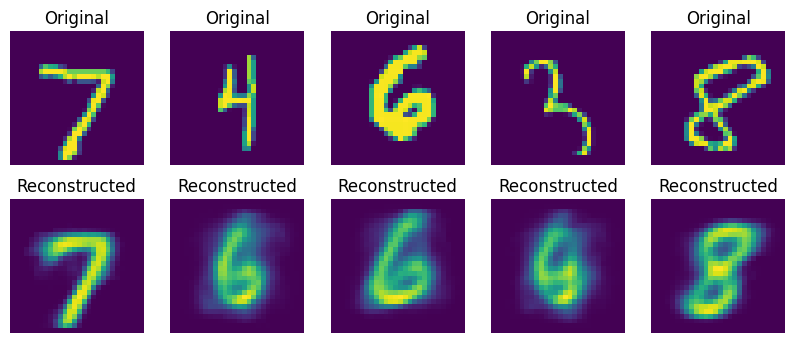

In [ ]:
visualize_reconstructions(vae_MNIST, test_dataloader_MNIST)

Processing: 100%|██████████| 157/157 [00:02<00:00, 61.17it/s] 


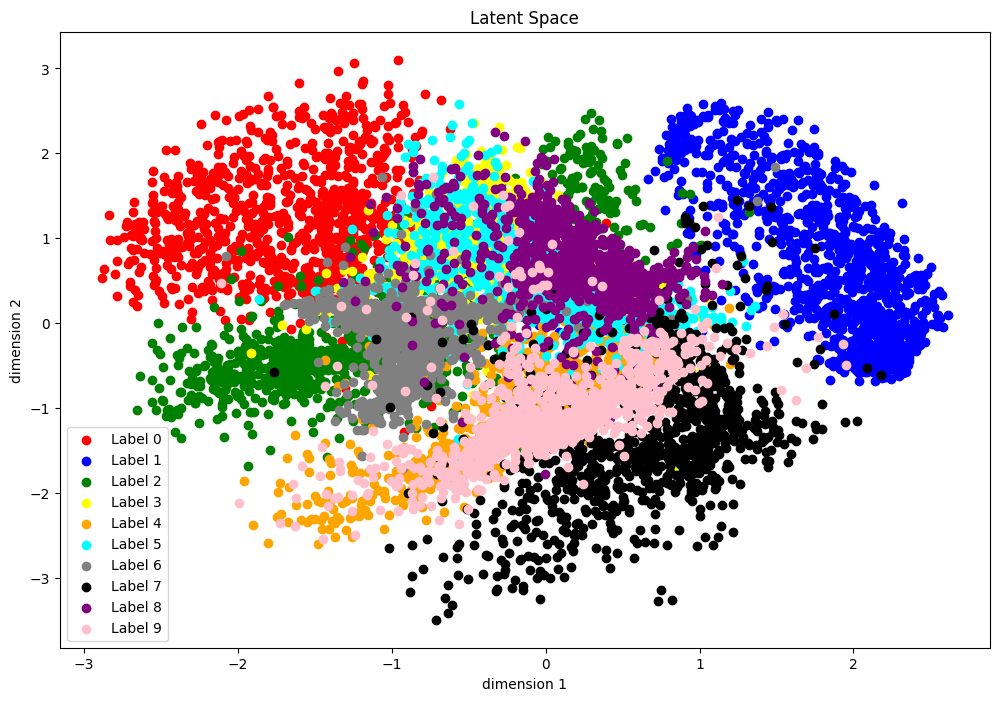

In [ ]:
visualize_latent_space(vae_MNIST, test_dataloader_MNIST, device)

## TO DO

## Analyse sur le nombre de tirages effectué

## Visualisation de l'espace latent en fonction de la variance: visualization de qq points dont la taille dépend de la variance

## Analyse sur la dimension de l espace latent ...
## Visualization de quelques samples générés de l'espaces latent

CE  QUE J AI A MODIFIER: 1 VISUALISATION DE L4ESPACE LATENT EN UTILISANT PCA  
2 VISUALISATION DE L ESPACE EN UTILISANT LA VARIANCE
3 AJOUT DES TEXTES D ANALYSE
